In [2]:
import numpy as np
import hoomd
import fresnel
import matplotlib.pyplot as plt
import scipy
import h5py
import gsd.hoomd
import itertools
import math
import time

In [2]:
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 5.5
integrator.forces.append(lj)

In [3]:
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.1))
integrator.methods.append(nvt)


In [4]:
m = np.int32(10)
N_particles = 4 * m**3
spacing = np.float64(1.3)
K = np.int32(np.ceil(N_particles**(1 / 3)))
L = K * spacing
x = np.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, 2*L, 0, 0, 0]
frame.particles.types = ['A']


In [5]:
%matplotlib inline
plt.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L[0], L[1], 2*L[2], 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L[0] * 2, L[1], L[2] * 4),
                                               look_at=(0, 0, 2),
                                               up=(0, 0, 1),
                                               height=L[2] * 2.8 + 2)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

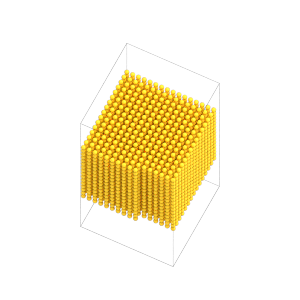

In [7]:
render(frame)

In [8]:
with gsd.hoomd.open(name='lattice.gsd', mode='w') as f:
    f.append(frame)

In [9]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='lattice.gsd')
simulation.operations.integrator = integrator
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.1)

In [10]:
snapshot = simulation.state.get_snapshot()
snapshot.particles.velocity[0:5]


array([[ 0.79410754,  0.00213487,  1.02183729],
       [ 0.42782485, -0.0321936 ,  0.20153609],
       [ 1.07036692, -0.92517656, -0.4674864 ],
       [-0.1341941 , -1.88013063,  1.15308972],
       [ 1.26405058,  1.00501176,  0.22557438]])

In [11]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
simulation.operations.computes.append(thermodynamic_properties)
simulation.always_compute_pressure = False
simulation.run(0)

In [12]:
thermodynamic_properties.kinetic_temperature

1.0689611546643718

In [13]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(thermodynamic_properties)
logger.add(simulation, quantities=['timestep', 'walltime'])
hdf5_writer = hoomd.write.HDF5Log(trigger=hoomd.trigger.Periodic(100),
                                  filename='log.h5',
                                  mode='w',
                                  logger=logger)
simulation.operations.writers.append(hdf5_writer)


In [29]:
t_start = time.time()
simulation.run(5000)
et = time.time() - t_start
print(et)

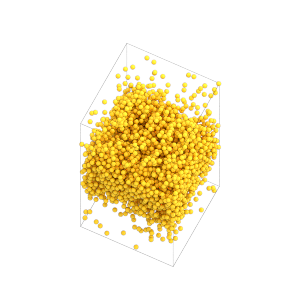

In [31]:
render(simulation.state.get_snapshot())


In [16]:
hoomd.write.GSD.write(state=simulation.state, filename='evaporating.gsd', mode='wb')


In [33]:
simulation.always_compute_pressure = True
simulation.run(1)
simulation.always_compute_pressure = False
thermodynamic_properties.pressure

0.05689364046523599

In [17]:
simulation.operations.writers.remove(hdf5_writer)


In [18]:
hdf5_file = h5py.File(name='log.h5', mode='r')


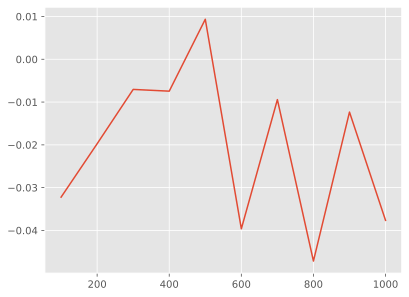

In [35]:
pd = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])
kd = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature'][:])
td = np.float64(hdf5_file['hoomd-data/Simulation/timestep'][:])
ptd = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure_tensor'][:])

p2d = 0.5*(ptd[:,0]+ptd[:,3]);
sd = (ptd[:,5]-p2d)/np.float64(2*L*L)

plt.plot(td, p2d)
# plt.plot(td,kd)


In [20]:
np.mean(sd[300:],axis=0)

/home/cericdahl/anaconda3/envs/md/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cericdahl/anaconda3/envs/md/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [43]:
np.std(sd[300:],axis=0)/np.sqrt(sd[300:].shape[0])

1.6112073425988424e-06

In [26]:
np.mean(kd[300:])

1.1982107979246606

In [29]:
np.std(kd[300:])/np.sqrt(kd[300:].shape[0])

0.0011337729761544736

In [ ]:
class SphereFilter(hoomd.filter.CustomFilter):
    def __init__(self, radius):
        self.radius = radius

    def __hash__(self):
        return hash((self.radius))

    def __eq__(self, other):
        return (isinstance(other, SphereFilter)
                and self.radius == other.radius)

    def __call__(self, state):
        with state.cpu_local_snapshot as snap:
            positions = snap.particles.position
            indices = (np.sum(positions*positions, axis=1) < (radius*radius))
            return numpy.copy(snap.particles.tag[indices])

thisfilter = SphereFilter(3.5)